# Validation of spatial aging clocks on external datasets

This notebook contains code for applying the spatial aging clocks to other datasets:
- Pilot 140-gene MERFISH
- Sagittal sections dataset
- Publicly available MERFISH aging dataset (this is actually in notebook 4A)
- Publicly available single-nuclei and single-cell RNAseq datasets.

It also contains code for plotting the density of predicted age and for computing relevant statistics for the comparison of predicted ages across groups.

**Associated manuscript figures/tables:**
- Figures: 2d
- Extended Data Figures: 6b,c,d,e,f
- Supplementary Table 12 (partial)


**Inputs required:**
- `results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_*.pkl` - pickle files containing sklearn Pipeline objects of spatial aging clocks (generated from `full_train_clock.py`)
- `data/integrated_aging_sagittal_clustered_registered_raw.h5ad` - AnnData object for sagittal sections dataset
- `data/pilot_merfish_2022/integrated_ingested.h5ad` - AnnData object for pilot MERFISH with Ingest-mapped cell type annotations (generated from `process_pilot_ingest.py`)
- assorted AnnData objects corresponding to external datasets from Allen et al. (2022) and Ximerakis et al. (2019) and reformatted according to steps in Methods section of manuscript 

**Conda environment used**: `requirements/merfish.txt`


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, lasso_path, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr, spearmanr
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp
from decimal import Decimal

from clock_preprocessing import *
from clock_prediction import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltype_palette = {'Neuron-Excitatory':'forestgreen',
                    'Neuron-Inhibitory':'lightgreen', 
                    'Neuron-MSN':'yellowgreen',
                    'Astrocyte': 'royalblue', 
                    'Microglia': 'aqua', 
                    'Oligodendrocyte': 'skyblue', 
                    'OPC': 'deepskyblue',
                    'Endothelial': 'red', 
                    'Pericyte': 'darkred', 
                    'VSMC': 'salmon', 
                    'VLMC': 'indianred',
                    'Ependymal': 'gray', 
                    'Neuroblast': 'sandybrown', 
                    'NSC':'darkorange', 
                    'Macrophage':'purple', 
                    'Neutrophil':'darkviolet',
                    'T cell':'magenta', 
                    'B cell':'orchid',
}

In [3]:
# function for computing confidence interval for correlations

def correlation_confidence_interval(r,n,ci=0.95):
    '''
    Given correlation (r), number of samples (n), and confidence interval (ci).
    Computes the confidence interval lower and upper bounds for r
    '''
    from scipy.stats import norm
    import math
    
    z = norm.ppf(1-(1-ci)/2)
    lower = math.tanh(math.atanh(r)-z/np.sqrt(n-3))
    upper = math.tanh(math.atanh(r)+z/np.sqrt(n-3))
    
    return((lower,upper))


# function for bootstrap sampling for statistics
def bootstrap_median_difference (df1, df2, ci=0.95, num_boot=1000):
    '''
    Given two dataframes with mouse_id and pred_age as columns, computes bootstrap confidence interval.
    Bootstrap samples by mouse_id within each dataframe separately.
    Computes difference of medians df1-df2.
    Computes confidence interval for these differences.
    '''
    med_diffs = []
    for i in range(num_boot):
        
        boot_df1_stacks = []
        draw1 = np.random.choice(np.unique(df1["mouse_id"].values), len(np.unique(df1["mouse_id"].values)), replace=True)
        for d1 in draw1:
            boot_df1_stacks.append(df1[df1["mouse_id"]==d1].copy())
        
        boot_df2_stacks = []
        draw2 = np.random.choice(np.unique(df2["mouse_id"].values), len(np.unique(df2["mouse_id"].values)), replace=True)
        for d2 in draw2:
            boot_df2_stacks.append(df2[df2["mouse_id"]==d2].copy())
        
        boot_df1 = pd.concat(boot_df1_stacks)
        boot_df2 = pd.concat(boot_df2_stacks)
        med_diffs.append(boot_df1["pred_age"].median() - boot_df2["pred_age"].median())
    
    # confidence interval
    lower = np.quantile(med_diffs, 0.025)
    upper = np.quantile(med_diffs, 0.975)
    
    return((lower,upper))

## Pilot MERFISH (140 genes)

In [4]:
adata = sc.read_h5ad("data/pilot_merfish_2022/integrated_clustered_regioned_raw.h5ad")

In [5]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, fill_missing="spage")

Astrocyte
Imputing values for 228 missing genes
Endothelial
Imputing values for 228 missing genes
Ependymal
Imputing values for 228 missing genes
Macrophage
Imputing values for 228 missing genes
Microglia
Imputing values for 228 missing genes
NSC
Imputing values for 228 missing genes
Neuroblast
Imputing values for 228 missing genes
Neuron-Excitatory
Imputing values for 228 missing genes
Neuron-Inhibitory
Imputing values for 228 missing genes
Neuron-MSN
Imputing values for 228 missing genes
OPC
Imputing values for 228 missing genes
Oligodendrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 228 missing genes
Pericyte
Imputing values for 228 missing genes
T cell
Imputing values for 228 missing genes
VLMC
Imputing values for 228 missing genes
VSMC
Imputing values for 228 missing genes


In [6]:
df.to_csv(f"results/clocks/applied/pilotraw_merfish_spatialsmooth_spage.csv")
adata.write_h5ad("results/clocks/anndata/pilotraw_merfish_spatialsmooth_spage.h5ad")

In [4]:
df = pd.read_csv(f"results/clocks/applied/pilotraw_merfish_spatialsmooth_spage.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

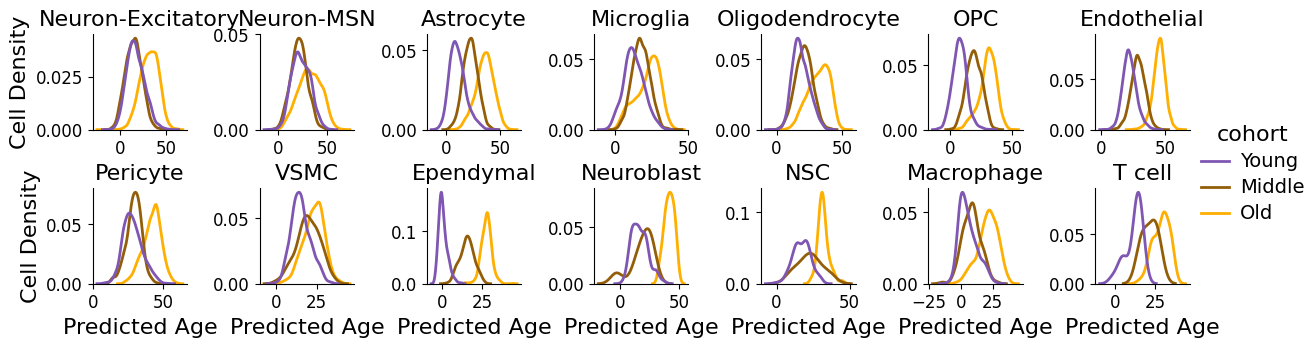

In [8]:
# Density of predicted ages across three ages

palette = {"Young":"#7F57B2",
           "Middle":"#935E09",
           "Old":"#FEAF00"}

ncols = 7
g = sns.displot(data=df, x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=12/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Young", "Middle", "Old"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/pilotraw_merfish_spatialsmooth_spage.pdf", bbox_inches='tight')
plt.show()

In [5]:
celltypes = ['Neuron-Excitatory',
 'Neuron-MSN',
 'Astrocyte',
 'Microglia',
 'Oligodendrocyte',
 'OPC',
 'Endothelial',
 'Pericyte',
 'VSMC',
 'Ependymal', 'Neuroblast', 'NSC',
 'Macrophage',
 'T cell']
comparisons = [["Old","Middle"],
               ["Old","Young"],
               ["Middle","Young"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
17.2
15.8
-1.4
10.9
9.41
-1.49
13.6
26.1
12.5
6.36
11.4
5.02
12.0
15.1
3.1
11.8
23.7
11.9
16.8
23.7
6.85
13.1
15.0
1.86
3.94
8.92
4.97
12.0
27.8
15.8
20.3
25.6
5.29
8.53
14.3
5.8
13.4
17.9
4.46
7.49
16.3
8.85
DIFF LOWER:
13.3
11.7
-10.2
9.11
7.79
-7.36
12.0
23.3
7.97
4.63
8.91
-2.06
11.3
14.5
1.05
10.4
23.2
6.58
16.0
22.9
4.14
11.0
13.0
-0.947
2.4
7.32
2.74
11.8
24.6
12.7
16.1
21.6
-20.3
-5.56
11.4
3.21
11.1
11.3
-3.2
1.62
12.2
2.2
DIFF UPPER:
27.2
24.4
5.79
15.7
11.3
1.61
17.1
28.0
14.2
11.5
12.5
7.33
14.0
16.2
4.35
17.5
24.2
12.9
19.4
25.2
8.54
16.9
17.2
3.21
4.75
9.63
7.06
12.3
28.5
16.3
47.4
28.5
6.8
9.49
18.0
22.3
16.3
20.2
7.32
13.9
26.2
20.7


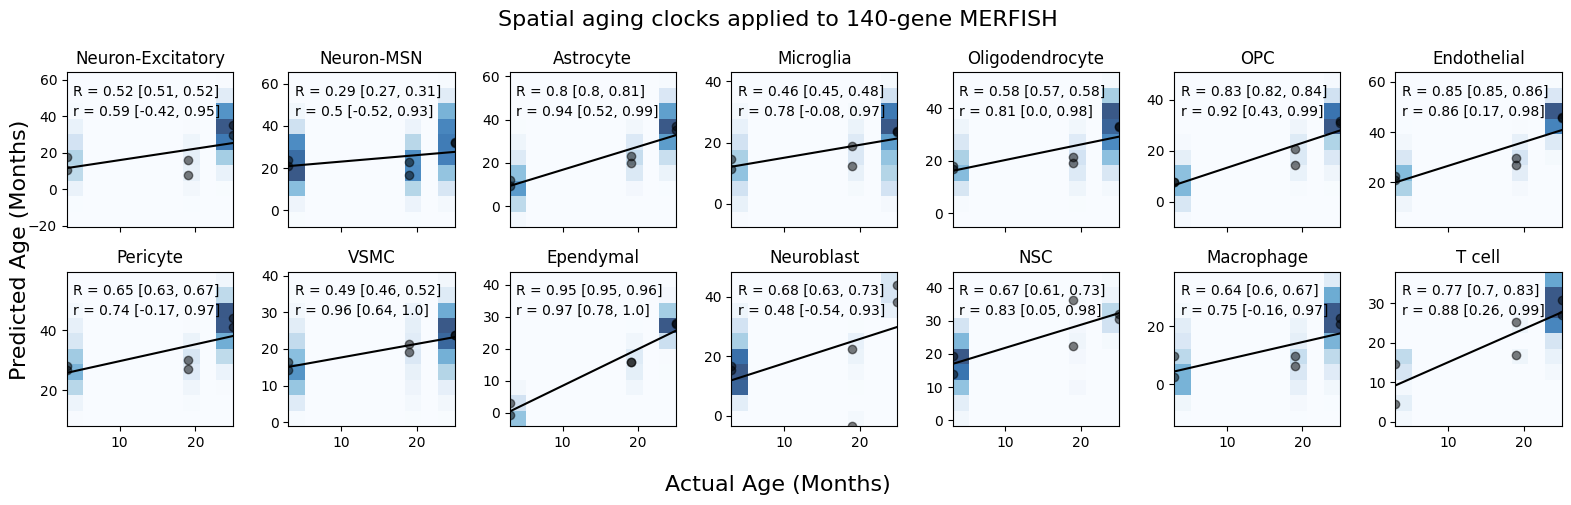

In [6]:
nrows = 2
ncols = 7

fig, axs = plt.subplots(2, 7, figsize=(16,5), sharex=True, sharey=False)

celltype_list = []
r_list = []
r_list_median = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(pd.unique(df.celltype).sort_values())[counter]
        sub_adata = df[df["celltype"]==celltype]
        
        # make plot
        axs[i,j].hist2d(sub_adata['age'], sub_adata['pred_age'], alpha=0.8, cmap='Blues', bins=10)
        axs[i,j].scatter(sub_adata.groupby(["mouse_id"])["age"].median(), sub_adata.groupby(["mouse_id"])["pred_age"].median(), c='k', alpha=0.5)
        b, a = np.polyfit(sub_adata.groupby(["mouse_id"])["age"].median(), sub_adata.groupby(["mouse_id"])["pred_age"].median(), deg=1)
        xseq = np.linspace(np.min(sub_adata['age']),np.max(sub_adata['age']),100)
        axs[i,j].plot(xseq, a + b * xseq, color="k")
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata['age'], sub_adata['pred_age'])
        ci = correlation_confidence_interval(r,len(sub_adata['age']),0.95)
        r_med,p_med = pearsonr(sub_adata.groupby(["mouse_id"])["age"].median(), sub_adata.groupby(["mouse_id"])["pred_age"].median())
        ci_med = correlation_confidence_interval(r_med,len(sub_adata.groupby(["mouse_id"])["age"].median()),0.95)
        mae = np.mean(np.abs(sub_adata['age']-sub_adata['pred_age']))
        axs[i,j].annotate(f"R = {round(r,2)} [{round(ci[0],2)}, {round(ci[1],2)}]", (0.04, 0.85), xycoords='axes fraction', fontsize=10)
        axs[i,j].annotate(f"r = {round(r_med,2)} [{round(ci_med[0],2)}, {round(ci_med[1],2)}]", (0.04, 0.72), xycoords='axes fraction', fontsize=10)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        r_list_median.append(r_med)
        
        counter += 1

# make figure
fig.suptitle("Spatial aging clocks applied to 140-gene MERFISH", fontsize=16)
fig.supxlabel("Actual Age (Months)", fontsize=16)
fig.supylabel("Predicted Age (Months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_PILOT_CI.pdf",
            bbox_inches='tight')
plt.show()

## Allen et al. snRNAseq data

In [3]:
adata = sc.read_h5ad("data/allen_2022_aging_merfish/snRNAseq_processed.h5ad")

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
tadata = sc.read_h5ad(f"results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_Microglia.h5ad")
clock_genes = tadata.var_names.copy()    

# subset into shared genes
intersection = np.intersect1d(clock_genes, adata.var_names)
adata = adata[:,intersection].copy()

adata

AnnData object with n_obs × n_vars = 79667 × 295
    obs: 'age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'n_genes', 'n_counts', 'clust_annot', 'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'mouse_id', 'cohort', 'age_weeks', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'feature_is_filtered', 'mean', 'std', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'age_colors', 'area_colors', 'batch_condition', 'clust_label_colors', 'final_clusts_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'schema_version', 'title', 'umap'
  

In [5]:
import gc
del tadata
gc.collect()

35896

In [6]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, smooth=False, pseudobulk_data=True, add_in_place=False,
                     normalize=False, standardize=False)

Astrocyte
Imputing values for 5 missing genes
Endothelial
Imputing values for 5 missing genes
Macrophage
Imputing values for 5 missing genes
Microglia
Imputing values for 5 missing genes
Neuron-Excitatory
Imputing values for 5 missing genes
Neuron-Inhibitory
Imputing values for 5 missing genes
Neuron-MSN
Imputing values for 5 missing genes
OPC
Imputing values for 5 missing genes
Oligodendrocyte
Imputing values for 5 missing genes
Pericyte
Imputing values for 5 missing genes
T cell
Imputing values for 5 missing genes
VLMC
Imputing values for 5 missing genes
other


In [7]:
df.to_csv(f"results/clocks/applied/allen_snRNAseq_aging_spatialsmooth.csv")
adata.write_h5ad("results/clocks/anndata/allen_snRNAseq_aging_spatialsmooth.h5ad")

In [6]:
df = pd.read_csv(f"results/clocks/applied/allen_snRNAseq_aging_spatialsmooth.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

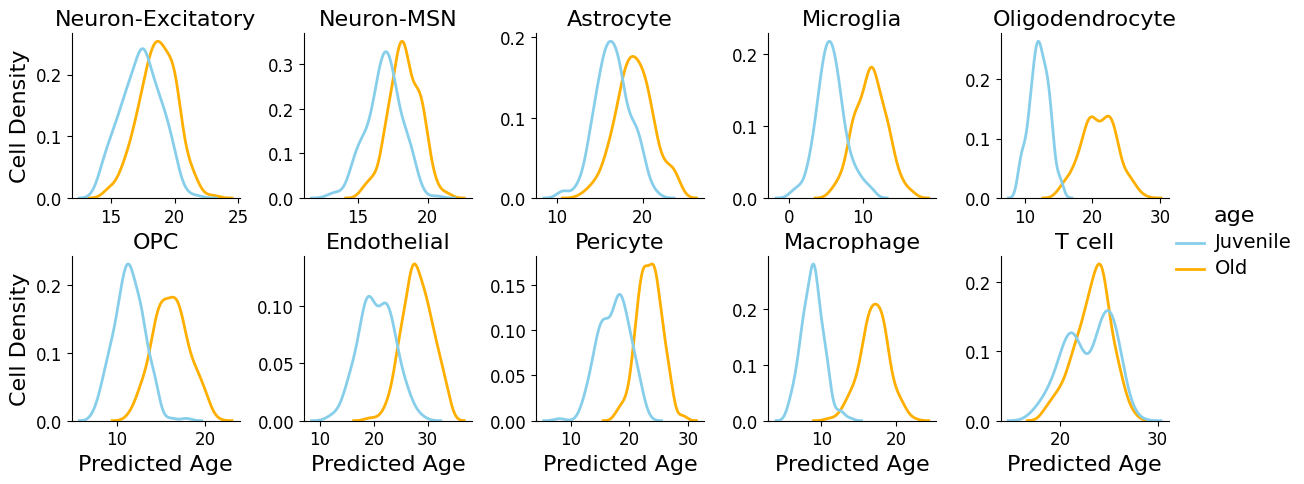

In [18]:
palette = {"Juvenile":"#87CEEB",
           "Old":"#FEAF00"}

df_aging = df[df['cohort']=="aging"].copy()
df_aging['age'] = df_aging['age'].astype(str)

df_aging['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df_aging['age']]

ncols = 5
g = sns.displot(data=df_aging, x="pred_age", hue="age", col="celltype", kind="kde", col_wrap=ncols, height=12/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Juvenile", "Old"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

#plt.savefig("plots/clocks/allen_snRNAseq_aging_spatialsmooth.pdf", bbox_inches='tight')
plt.show()

In [7]:
celltypes = ['Neuron-Excitatory',
 'Neuron-MSN',
 'Astrocyte',
 'Microglia',
 'Oligodendrocyte',
 'OPC',
 'Endothelial',
 'Pericyte',
 'Macrophage',
 'T cell']
comparisons = [[20.93, 0.93]]
cond_label = "age"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
1.22
1.34
2.61
5.5
8.85
4.71
7.43
5.63
8.25
0.143
DIFF LOWER:
1.06
0.854
2.06
4.96
7.02
3.56
4.4
3.46
7.44
-2.74
DIFF UPPER:
1.57
1.81
3.05
6.0
10.6
5.77
10.7
8.87
9.21
3.46


## Ximerakis et al. (scRNAseq)

In [82]:
adata = sc.read_h5ad("data/external_RNAseq/ximerakis_2019_scRNAseq/scRNAseq_aging_processed.h5ad")

In [83]:
tadata = sc.read_h5ad(f"results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_Microglia.h5ad")
clock_genes = tadata.var_names.copy()    

# subset into shared genes
intersection = np.intersect1d(clock_genes, adata.var_names)
adata = adata[:,intersection].copy()

adata

AnnData object with n_obs × n_vars = 37069 × 264
    obs: 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI', 'mouse_id', 'cohort', 'age', 'celltype'

In [84]:
import gc
del tadata
gc.collect()

43587

In [85]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, smooth=False, pseudobulk_data=True, add_in_place=False,
                     normalize=False, standardize=False)

ABC
ARP
Astrocyte
Imputing values for 36 missing genes
CPC
DC
Ependymal
Imputing values for 36 missing genes
ExcludePerfusion
Hb_VC
MNC
Macrophage
Imputing values for 36 missing genes
Microglia
Imputing values for 36 missing genes
NEUR_immature
NEUR_mature
NSC
Imputing values for 36 missing genes
NendC
Neuroblast
Imputing values for 36 missing genes
Neutrophil
Imputing values for 36 missing genes
OEG
OPC
Imputing values for 36 missing genes
Oligodendrocyte
Imputing values for 36 missing genes
TNC


In [11]:
# df.to_csv(f"results/clocks/applied/ximerakis_scRNAseq_aging_spatialsmooth.csv")
# adata.write_h5ad("results/clocks/anndata/ximerakis_scRNAseq_aging_spatialsmooth.h5ad")

In [8]:
df = pd.read_csv(f"results/clocks/applied/ximerakis_scRNAseq_aging_spatialsmooth.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

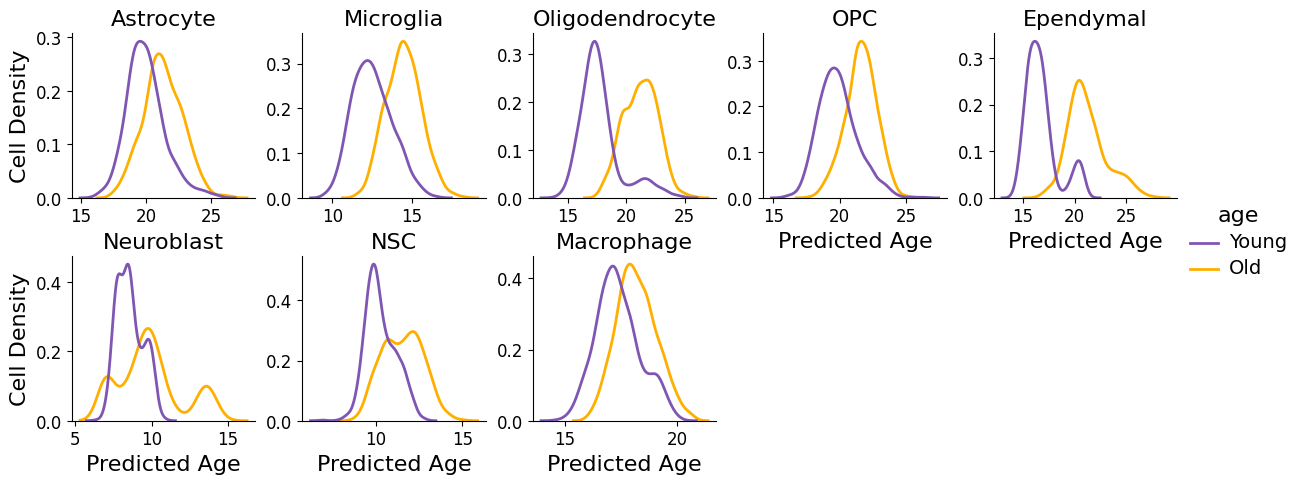

In [13]:
palette = {"Young":"#7F57B2",
           "Old":"#FEAF00"}

df_aging = df[df['cohort']=="aging"].copy()
df_aging['age'] = df_aging['age'].astype(str)

df_aging['age'] = [{'2-3mo':'Young','21-22mo':'Old'}[x] for x in df_aging['age']]

ncols = 5
g = sns.displot(data=df_aging, x="pred_age", hue="age", col="celltype", kind="kde", col_wrap=ncols, height=12/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Young", "Old"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/ximerakis_scRNAseq_aging_spatialsmooth.pdf", bbox_inches='tight')
plt.show()

In [9]:
celltypes = [
 'Astrocyte',
 'Microglia',
 'Oligodendrocyte',
 'OPC',
 'Ependymal',
 'Neuroblast',
 'NSC',
 'Macrophage']
comparisons = [['21-22mo', '2-3mo']]
cond_label = "age"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
1.39
2.04
3.84
1.92
4.45
1.2
1.47
0.859

DIFF LOWER:
0.535
1.07
2.73
0.953
3.28
-1.08
0.171
0.0636

DIFF UPPER:
2.07
2.73
4.64
2.55
5.78
3.97
2.25
1.49


## Sagittal Sections (MERFISH 300 genes)

In [5]:
adata = sc.read_h5ad("data/integrated_aging_sagittal_clustered_registered_raw.h5ad")
adata = adata[(adata.obs.clusters!="1")].copy()
adata.obs['cohort'] = ["Young (<9 months)" if x < 10 else "Old (>19 months)" for x in adata.obs.age]

In [6]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

Astrocyte
B cell
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
OPC
Oligodendrocyte
Pericyte
T cell
Unknown
VLMC
VSMC


In [7]:
# df.to_csv(f"results/clocks/applied/sagittal_spatialsmooth.csv")
# adata.write_h5ad("results/clocks/anndata/sagittal_spatialsmooth.h5ad")

In [10]:
df = pd.read_csv(f"results/clocks/applied/sagittal_spatialsmooth.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

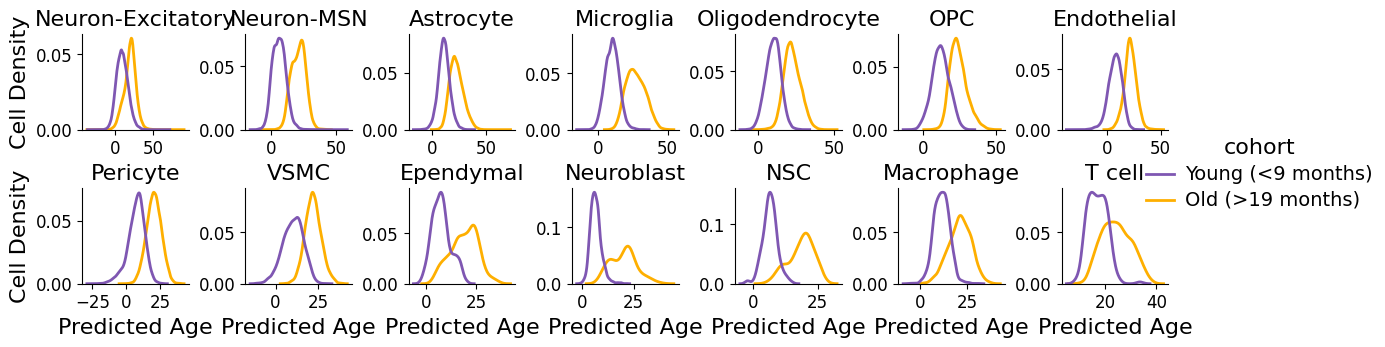

In [9]:
palette = {"Young (<9 months)":"#7F57B2",
           "Old (>19 months)":"#FEAF00"}

ncols = 7
g = sns.displot(data=df, x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=12/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Young (<9 months)", "Old (>19 months)"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/sagittal_spatialsmooth.pdf", bbox_inches='tight')
plt.show()

In [11]:
# compute stats

celltypes = ['Neuron-Excitatory',
 'Neuron-MSN',
 'Astrocyte',
 'Microglia',
 'Oligodendrocyte',
 'OPC',
 'Endothelial',
 'Pericyte',
 'VSMC',
 'Ependymal',
 'Neuroblast',
 'NSC',
 'Macrophage',
 'T cell']
comparisons = [["Old (>19 months)", "Young (<9 months)"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
10.9
15.3
11.1
16.5
12.0
11.7
13.9
12.4
11.3
12.2
14.4
13.4
9.96
7.09

DIFF LOWER:
6.6
9.26
7.2
11.4
7.96
8.03
9.3
7.98
6.88
4.86
2.9
4.31
4.8
1.05

DIFF UPPER:
15.4
21.3
16.3
23.8
17.8
16.2
19.7
19.0
16.6
17.6
15.5
14.5
13.6
11.7


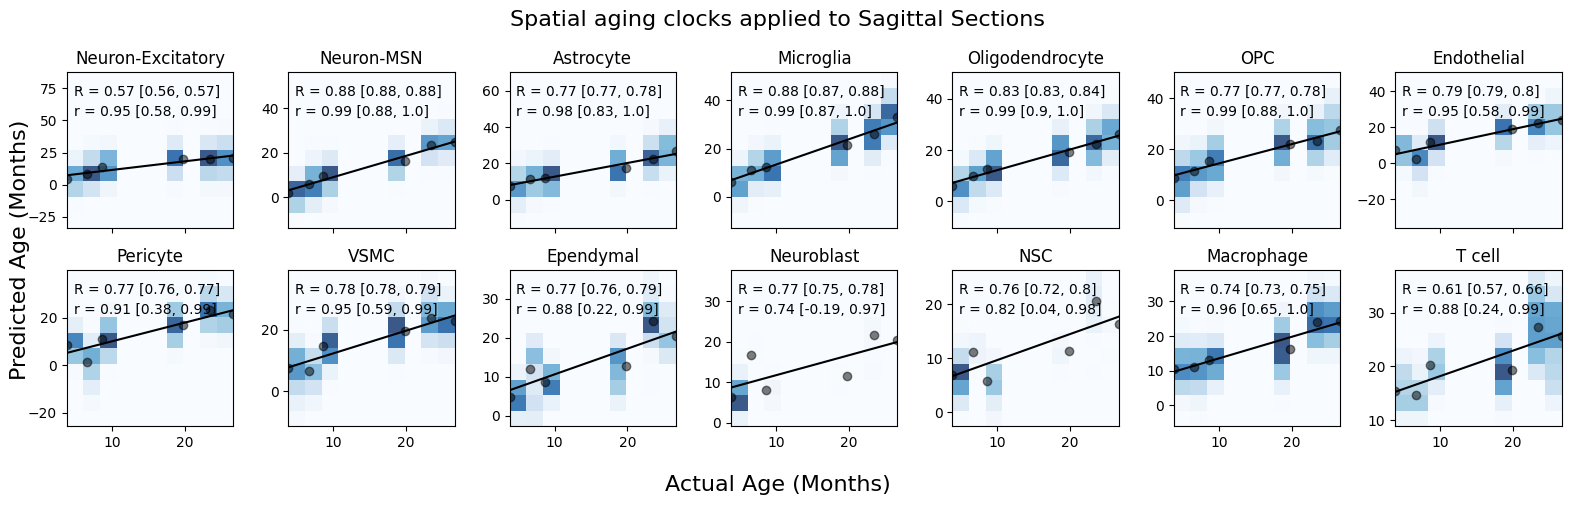

In [8]:
nrows = 2
ncols = 7

fig, axs = plt.subplots(2, 7, figsize=(16,5), sharex=True, sharey=False)

celltype_list = []
r_list = []
r_list_median = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(pd.unique(df.celltype).sort_values())[counter]
        sub_adata = df[df["celltype"]==celltype]
        
        # make plot
        axs[i,j].hist2d(sub_adata['age'], sub_adata['pred_age'], alpha=0.8, cmap='Blues', bins=10)
        axs[i,j].scatter(sub_adata.groupby(["mouse_id"])["age"].median(), sub_adata.groupby(["mouse_id"])["pred_age"].median(), c='k', alpha=0.5)
        b, a = np.polyfit(sub_adata.groupby(["mouse_id"])["age"].median(), sub_adata.groupby(["mouse_id"])["pred_age"].median(), deg=1)
        xseq = np.linspace(np.min(sub_adata['age']),np.max(sub_adata['age']),100)
        axs[i,j].plot(xseq, a + b * xseq, color="k")
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata['age'], sub_adata['pred_age'])
        ci = correlation_confidence_interval(r,len(sub_adata['age']),0.95)
        r_med,p_med = pearsonr(sub_adata.groupby(["mouse_id"])["age"].median(), sub_adata.groupby(["mouse_id"])["pred_age"].median())
        ci_med = correlation_confidence_interval(r_med,len(sub_adata.groupby(["mouse_id"])["age"].median()),0.95)
        mae = np.mean(np.abs(sub_adata['age']-sub_adata['pred_age']))
        axs[i,j].annotate(f"R = {round(r,2)} [{round(ci[0],2)}, {round(ci[1],2)}]", (0.04, 0.85), xycoords='axes fraction', fontsize=10)
        axs[i,j].annotate(f"r = {round(r_med,2)} [{round(ci_med[0],2)}, {round(ci_med[1],2)}]", (0.04, 0.72), xycoords='axes fraction', fontsize=10)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        r_list_median.append(r_med)
        
        counter += 1

# make figure
fig.suptitle("Spatial aging clocks applied to Sagittal Sections", fontsize=16)
fig.supxlabel("Actual Age (Months)", fontsize=16)
fig.supylabel("Predicted Age (Months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_SAGITTAL_CI.pdf",
            bbox_inches='tight')
plt.show()

## Sagittal (Cerebellum)

In [11]:
adata = sc.read_h5ad("data/integrated_aging_sagittal_clustered_registered_raw.h5ad")
adata = adata[(adata.obs.clusters!="1")].copy()
adata = adata[adata.obs.region=="CB"]
adata.obs['cohort'] = ["Young (<9 months)" if x < 10 else "Old (>19 months)" for x in adata.obs.age]

/local/scratch/edsun/slrmtmp.42837413/ipykernel_44258/2051845671.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cohort'] = ["Young (<9 months)" if x < 10 else "Old (>19 months)" for x in adata.obs.age]
/home/edsun/.conda/envs/merfish/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [12]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

Astrocyte
B cell
Endothelial
Ependymal
Macrophage
Microglia
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
OPC
Oligodendrocyte
Pericyte
T cell
Unknown
VLMC
VSMC


In [13]:
# df.to_csv(f"results/clocks/applied/sagittal_spatialsmooth_CB.csv")
# adata.write_h5ad("results/clocks/anndata/sagittal_spatialsmooth_CB.h5ad")

In [12]:
df = pd.read_csv(f"results/clocks/applied/sagittal_spatialsmooth_CB.csv")

# filter for at least 100 cells
keep_cts = np.unique(df.celltype)[np.unique(df.celltype,return_counts=True)[1]>100]
df = df[df['celltype'].isin(keep_cts)]

df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

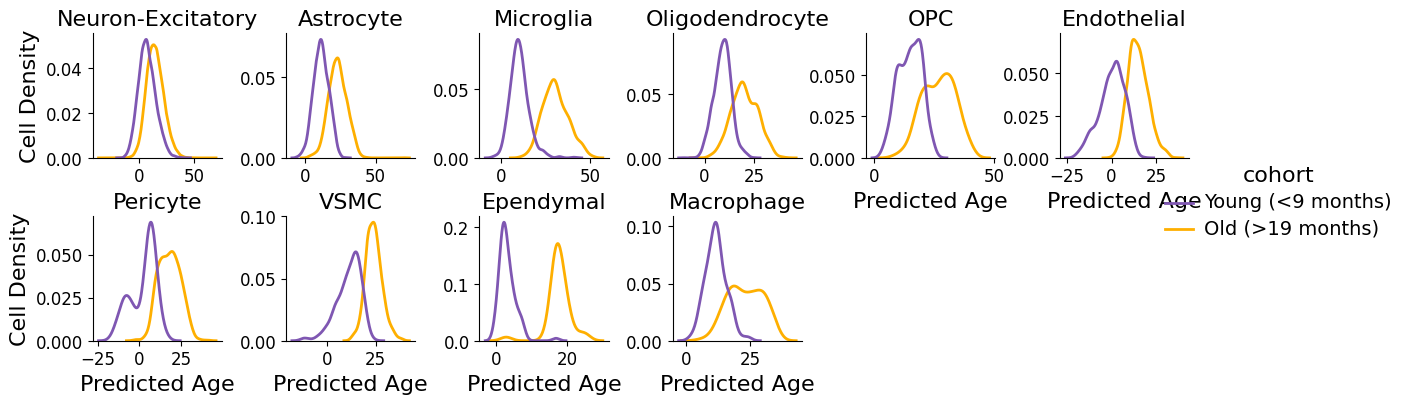

In [15]:
palette = {"Young (<9 months)":"#7F57B2",
           "Old (>19 months)":"#FEAF00"}

ncols = 6
g = sns.displot(data=df, x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=12/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Young (<9 months)", "Old (>19 months)"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/sagittal_spatialsmooth_CB.pdf", bbox_inches='tight')
plt.show()

In [13]:
# compute stats

celltypes = ['Neuron-Excitatory',
 'Astrocyte',
 'Microglia',
 'Oligodendrocyte',
 'OPC',
 'Endothelial',
 'Pericyte',
 'VSMC',
 'Ependymal',
 'Macrophage']
comparisons = [["Old (>19 months)", "Young (<9 months)"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
7.34
11.7
20.2
10.6
12.2
13.3
13.2
11.4
15.0
11.4

DIFF LOWER:
4.13
6.65
14.7
5.09
5.08
7.9
6.61
8.29
-0.11
5.33

DIFF UPPER:
12.0
17.6
27.0
17.0
18.6
20.0
27.3
18.5
15.2
19.6


## Sagittal (Olfactory Bulb)

In [17]:
adata = sc.read_h5ad("data/integrated_aging_sagittal_clustered_registered_raw.h5ad")
adata = adata[(adata.obs.clusters!="1")].copy()
adata = adata[adata.obs.region=="OB"]
adata.obs['cohort'] = ["Young (<9 months)" if x < 10 else "Old (>19 months)" for x in adata.obs.age]

/local/scratch/edsun/slrmtmp.42837413/ipykernel_44258/1015845551.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cohort'] = ["Young (<9 months)" if x < 10 else "Old (>19 months)" for x in adata.obs.age]
/home/edsun/.conda/envs/merfish/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [18]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

Astrocyte
B cell
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
OPC
Oligodendrocyte
Pericyte
T cell
Unknown
VLMC
VSMC


In [19]:
# df.to_csv(f"results/clocks/applied/sagittal_spatialsmooth_OB.csv")
# adata.write_h5ad("results/clocks/anndata/sagittal_spatialsmooth_OB.h5ad")

In [14]:
df = pd.read_csv(f"results/clocks/applied/sagittal_spatialsmooth_OB.csv")

# filter for at least 100 cells
keep_cts = np.unique(df.celltype)[np.unique(df.celltype,return_counts=True)[1]>100]
df = df[df['celltype'].isin(keep_cts)]

df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

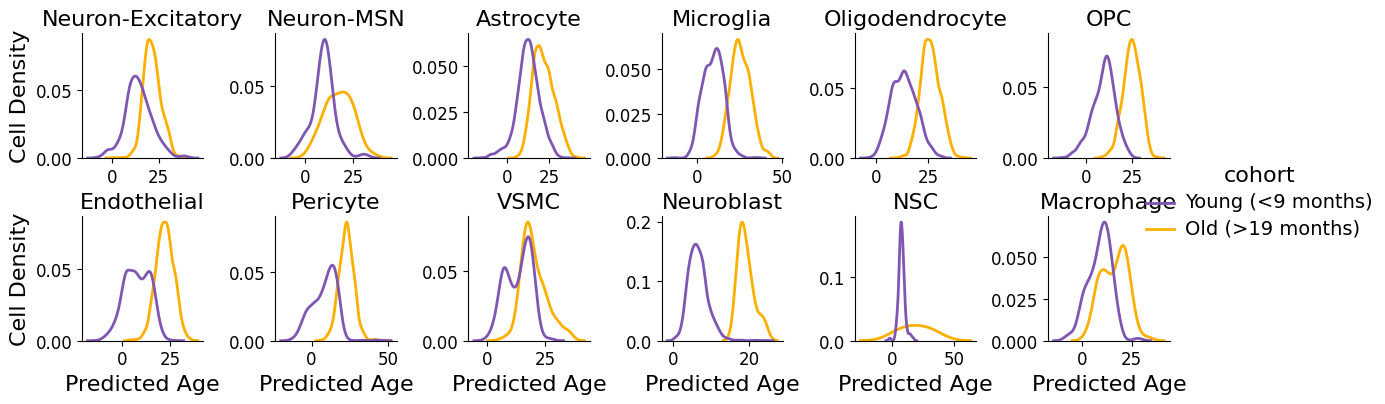

In [21]:
palette = {"Young (<9 months)":"#7F57B2",
           "Old (>19 months)":"#FEAF00"}

ncols = 6
g = sns.displot(data=df, x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=12/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Young (<9 months)", "Old (>19 months)"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/sagittal_spatialsmooth_OB.pdf", bbox_inches='tight')
plt.show()

In [15]:
# compute stats

celltypes = ['Neuron-Excitatory',
 'Neuron-MSN',
 'Astrocyte',
 'Microglia',
 'Oligodendrocyte',
 'OPC',
 'Endothelial',
 'Pericyte',
 'VSMC',
 'Neuroblast',
 'NSC',
 'Macrophage']
comparisons = [["Old (>19 months)", "Young (<9 months)"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
7.47
7.76
8.5
15.4
12.5
14.5
14.5
12.9
4.22
12.2
11.5
7.56

DIFF LOWER:
5.58
3.21
5.11
9.89
7.39
11.1
7.76
7.68
-0.0569
-2.65
-8.39
-0.629

DIFF UPPER:
10.6
18.0
12.7
22.8
18.2
18.4
20.9
23.4
16.8
14.0
24.9
17.9
